#R-CNN implementation from scratch for Human Detection
###Ali Rahmani Nejad @arnejad

Using [INRIAPerson dataset](http://pascal.inrialpes.fr/data/human/), a human detector is implemented.
The procedure is written from scratch using R-CNN procedure published in paper [Girshick, Ross, et al. "Rich feature hierarchies for accurate object detection and semantic segmentation." Proceedings of the IEEE conference on computer vision and pattern recognition. 2014.](http://openaccess.thecvf.com/content_cvpr_2014/papers/Girshick_Rich_Feature_Hierarchies_2014_CVPR_paper.pdf)

Imports

In [1]:
import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

Reading INRIA dataset

In [2]:
!wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
!tar -xf INRIAPerson.tar
! ls INRIAPerson/

--2020-12-16 17:59:14--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
           => ‘INRIAPerson.tar.1’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE INRIAPerson.tar ... 1016094720
==> PASV ... done.    ==> RETR INRIAPerson.tar ... done.
Length: 1016094720 (969M) (unauthoritative)

INRIAPerson.tar.1   100%[===================>] 969.02M  31.4MB/s    in 39s     

2020-12-16 17:59:54 (25.1 MB/s) - ‘INRIAPerson.tar.1’ saved [1016094720]

70X134H96  96X160H96  Test  test_64x128_H96  Train  train_64x128_H96


##Preparing train and test sets


A predefined function to display images


In [4]:
def displayImg(img):
    imgplot = plt.imshow(img)
    plt.show()

Making a patch extraction function for future purposes

In [5]:
def randomPatchExtractor(image, height, width):
    x = random.randint(0, image.shape[1]-width)
    y = random.randint(0, image.shape[0]-height)
    return image[y:y+height, x:x+width, 0:3]

Defining a function to crop the the margin of the image

In [6]:
def cropMargin(img):
    h = img.shape[0]
    w = img.shape[1]
    margH = int((h-PATCH_H)/2)
    margW = int((w-PATCH_W)/2)

    return img[margH:h-margH, margW:w-margW, :]

Testing the random patch extractor function.
The resulting patch must be 96-by-160, since this is our predefined size

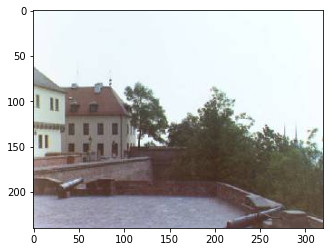

(160, 96, 3)


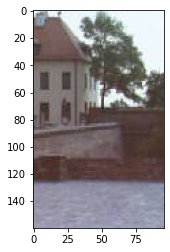

In [7]:
img = mpimg.imread("INRIAPerson/Train/neg/00000002a.png")
displayImg(img)

res = randomPatchExtractor(img, 160, 96)
print(res.shape)
displayImg(res)

The following function is responsible for reading images in a folder and build a dataset.
If the input folder is for positive instances, only the image is read and prepared in an 4D array
Otherwise, random patch extraction by the default window size is conducted to obtain negative patches.

In [8]:
def createDataset(img_folder, isPosSet):
    
    img_data_array=[]
    train_lbls=[]
    for file in os.listdir(img_folder):
       
        image_path= os.path.join(img_folder,  file)
        image= cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = mpimg.imread(image_path)
        # image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        # print(image.shape)
        if not(isPosSet):
            for i in range(0,2):
                imToAdd = randomPatchExtractor(image, PATCH_H, PATCH_W)
                imToAdd = cv2.resize(imToAdd, (VGG_INP_H, VGG_INP_W), interpolation = cv2.INTER_AREA)
                imToAdd = imToAdd.astype('float32')
                imToAdd /= 255
                img_data_array.append(imToAdd)
                train_lbls.append(isPosSet)
        else:
            image=cropMargin(image)
            image = cv2.resize(image, (VGG_INP_H, VGG_INP_W), interpolation = cv2.INTER_AREA)
            image = image.astype('float32')
            image = np.delete(image, 3,axis=2)
            img_data_array.append(image)
            train_lbls.append(isPosSet)


    return img_data_array , train_lbls

Let's the define the size of that patches to extract

In [9]:
PATCH_W = 64
PATCH_H = 128

VGG_INP_H = 224
VGG_INP_W = VGG_INP_H

Reading positive cropped images and making set for train.

In [10]:
trainPosFolder=r'INRIAPerson/train_64x128_H96/pos'

train1, labels1 =createDataset(trainPosFolder, 1)

(2416, 224, 224, 3)


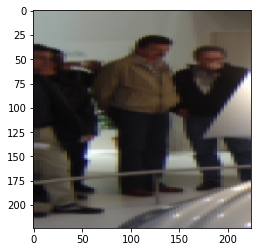

In [11]:
# Checking to see that images are read properly
train1 = np.array(train1)
print(train1.shape)
displayImg(train1[5])

Reading negative images and extracting random patches with predefined size bt random patch extraction for negative images. Since there is not human in any of the negative images, any random patch with the default size will do the work.

(2436, 224, 224, 3)


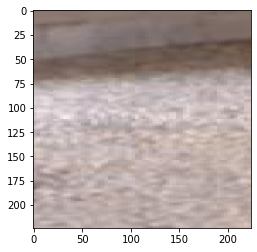

In [12]:
trainNegFolder=r'INRIAPerson/Train/neg'

train2, labels2 =createDataset(trainNegFolder, 0)
train2 = np.array(train2)

# Checking to see that images are read  properly
print(train2.shape)
displayImg(train2[5])

concatenate the  negative and positive dataset.

In [14]:
# Creating final labels set
labels1 = np.array(labels1)
labels2 = np.array(labels2)

trainLblSet = np.concatenate((labels1, labels2), axis=0)
del labels1
del labels2
trainLblSet.shape

(4852,)

In [15]:
# Creating final images set

trainImgSet = np.concatenate((train1, train2), axis=0)
del train1
del train2
trainImgSet.shape

(4852, 224, 224, 3)

The data for training is ready. Now, let's prepare the test set.

In [16]:
testPosFolder = r'INRIAPerson/test_64x128_H96/pos/'
testImgsPos, testLablesPos = createDataset(testPosFolder, 1)
testImgsPos = np.array(testImgsPos)
testLablesPos = np.array(testLablesPos)
testImgsPos.shape

(1132, 224, 224, 3)

In [17]:
testNegFolder=r'INRIAPerson/Train/neg'
testImgsNeg, testLablesNeg = createDataset(testNegFolder,0)
testImgsNeg = np.array(testImgsNeg)
testLablesNeg = np.array(testLablesNeg)
testImgsNeg.shape

(2436, 224, 224, 3)

In [18]:
testImgSet = np.concatenate((testImgsPos, testImgsNeg), axis=0)
testLblSet = np.concatenate((testLablesPos, testLablesNeg), axis=0)
del testImgsPos
del testImgsNeg
del testLablesPos
del testLablesNeg
print(testImgSet.shape)
print(testLblSet.shape)

(3568, 224, 224, 3)
(3568,)


##Training
Now that data is prepared, the deep neural network can be made to pipe through into SVM algorithm.
In this code the VGGNet has been used as out DL architecture.

In [19]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from sklearn import svm
import gc

Transfer Learning is applied for this project. This network has been pre-trained on ImageNet dataset. The weights can be used.

In [20]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [22]:
model.fit(trainImgSet,trainLblSet,batch_size = 64,epochs = 3,validation_split=.05,shuffle = True, callbacks=[MyCustomCallback()])

Epoch 1/3
73/73 [==============================] - 21s 286ms/step - loss: 2.6378 - acc: 0.8677 - val_loss: 0.7958 - val_acc: 0.8601
Epoch 2/3
73/73 [==============================] - 19s 263ms/step - loss: 0.1385 - acc: 0.9642 - val_loss: 0.0319 - val_acc: 0.9835
Epoch 3/3
73/73 [==============================] - 20s 273ms/step - loss: 0.0422 - acc: 0.9816 - val_loss: 0.0924 - val_acc: 0.9671


Now based on the obtained Deep Network, we map each image to its learnt feature. Patches' feature and label will be used to train the SVM algorithm.
For this purpose, the last layer of the Deep Net must be removed.

In [23]:
final_model = keras.Model(inputs=model.input, outputs=model.get_layer('fc2').output)

# Due to lack of memory, we have to run each 100 describe individually in a loop
trainImgFeats = []

for i in range(0, trainImgSet.shape[0]+1,100):
    features = final_model(trainImgSet[i:i+100])
    if trainImgFeats == []:
        trainImgFeats = np.array(features)
    else:
        trainImgFeats = np.concatenate((trainImgFeats, features), axis=0)

trainImgFeats.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


(4852, 4096)

Now the features are ready, we can pass it on to the SVM to learn a classification plane

In [24]:
clf = svm.SVC()
clf.fit(trainImgFeats, trainLblSet)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
#clearing
del trainImgFeats

## Testing

In this part, that test data will be transformed into the standard feature representation and get passed on to SVM for prediction

In [26]:
#transforming images into feature
testImgFeats = []
for i in range(0, testImgSet.shape[0]+1,100):
    features = final_model(testImgSet[i:i+100])
    if testImgFeats == []:
        testImgFeats = np.array(features)
    else:
        testImgFeats = np.concatenate((testImgFeats, features), axis=0)

testImgFeats.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


(3568, 4096)

In [28]:
preds = clf.predict(testImgFeats)
preds = np.array(preds)
acc = np.sum(preds==testLblSet)/testImgSet.shape[0]
print("the accuracy is:")
print(acc)

the accuracy is:
0.9887892376681614
